In [1]:
from robust_hw import columns, extract_rotations, interpolate, integrate, read_hdf, read_csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.ndimage import uniform_filter, gaussian_filter

In [2]:
input = np.loadtxt('data/debug3.log', delimiter=',')

In [3]:
period = 10
# log_path = 'data/Z-230901A.csv'
log_path = 'data/output.csv'

theta_raw = np.unwrap(read_csv(log_path, columns['theta']))

freq_raw = -1.0 * read_csv(log_path, 'Sensor1 [Fundamental freq]')
theta_ext, freq_ext = extract_rotations(theta_raw, freq_raw)
freq_sgn = integrate(freq_ext, np.zeros(freq_ext.size), period)
freq_bgd = interpolate(freq_ext, period, period - 2)
freq_int = integrate(freq_ext, freq_bgd, period)

In [32]:
s1_factor = read_csv(log_path, columns['s1_factor'])
s1_background = read_csv(log_path, columns['s1_bgd'])
s1_signal = read_csv(log_path, columns['s1_sgn'])
s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S1 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

_, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S1 Smooth signal] (layers)'))

In [40]:
s1_factor = read_csv(log_path, columns['s2_factor'])
s1_background = read_csv(log_path, columns['s2_bgd'])
s1_signal = read_csv(log_path, columns['s2_sgn'])
s1_cleaned_signal = read_csv(log_path, 'Mag3 [QCM,S2 cleaned signal] (um/rot)')
factor = 1e-3

theta_ext, signal = extract_rotations(theta_raw, s1_signal)
theta_ext, background = extract_rotations(theta_raw, s1_background)

_, log_signal = extract_rotations(theta_raw, read_csv(log_path, 'Mag3 [Holt Winters feedback,S2 Smooth signal] (layers)'))

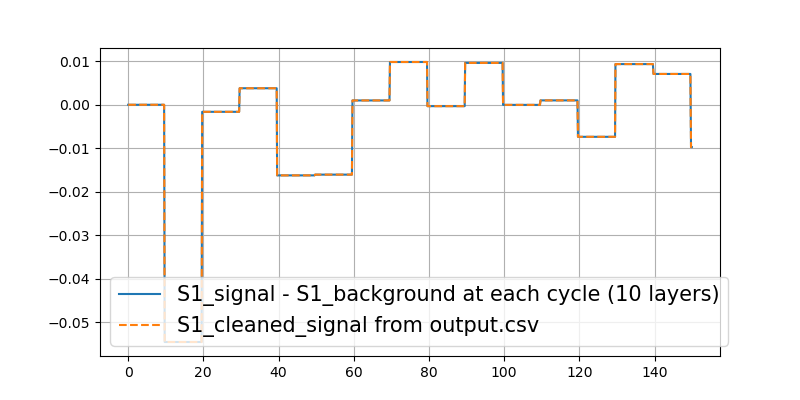

In [41]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw, freq_raw)
# ax.plot(theta_ext, freq_ext)
ax.plot(theta_raw / (2 * np.pi), factor * (s1_signal - s1_background), label="S1_signal - S1_background at each cycle (10 layers)")
# ax.plot(theta_ext[::period], factor * (signal - background)[::period], label="S1_signal - S1_background at each cycle (10 layers)")
ax.plot(theta_raw / (2 * np.pi), s1_cleaned_signal, linestyle='dashed', label="S1_cleaned_signal from output.csv")
# ax.plot(theta_ext[::period], series, label="S1 smoothing input from debug.log")
# ax.plot(theta_ext[::period][5:], input[:26, 1])

ax.legend(fontsize=15)
ax.grid(True)
# ax.set_ylim(0.85, 1.05)
plt.show()

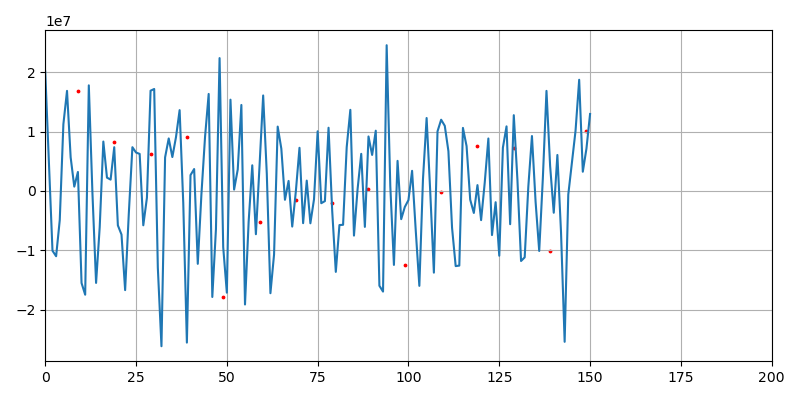

In [14]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(theta_ext, np.gradient(freq_ext))
ax.scatter(theta_ext[period - 1::period], np.gradient(freq_ext)[period - 4::period], s=3, c='r')
ax.grid(True)

ax.set_xlim(0, 200)
fig.tight_layout()
plt.show()

# Robust smoothing

In [24]:
from robust_hw import create_smoother, initialise, smoothing_step
import jax.numpy as jnp
from tqdm.auto import tqdm

In [42]:
# series of signal - background
theta = theta_ext[::period]
# series = freq_int[::period]
series = factor * (signal - background)[::period]

# series /= series.max()

# results of a training
smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance = 1, 1, 1

#creating a smoother object
smoother = create_smoother(smoothe_over_signal, smoothe_over_gradient, smoothe_over_variance)

# skipping first n_start points and allocating n_warmup points to create an initial state
n_start, n_warmup = 1, 10

warmup, samples = (jnp.array(series[n_start:n_start + n_warmup]),
                   jnp.array(series[n_start + n_warmup:]))

step = smoothing_step(smoother)

# creating an initial state
state = initialise(smoother, warmup)

# performing real-time smoothing
result = []
states = []
for elem in tqdm(samples):
    smoothed, state = step(elem, state)
    result.append(smoothed)
    states.append(state)

  0%|          | 0/5 [00:00<?, ?it/s]

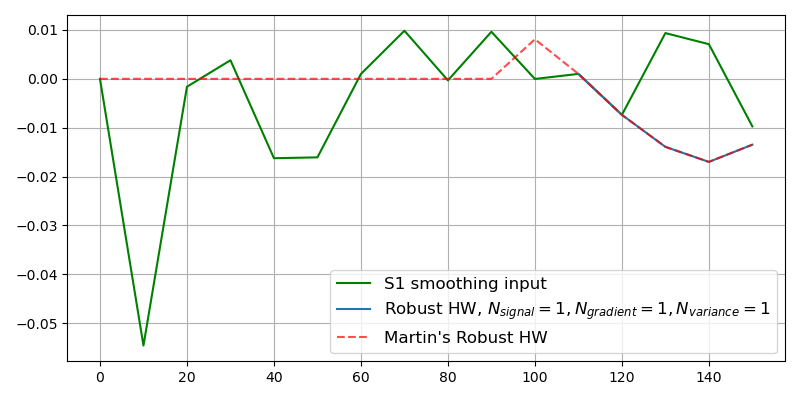

In [43]:
import matplotlib.pyplot as plt

%matplotlib widget
fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(theta_raw / (2 * np.pi), old_s1_ftr, c='b', alpha=0.7, linestyle='dashed', label="s1 factor")
# ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")
# ax.plot(theta[n_start + n_warmup:], [state.moment for state in states])
# ax.scatter(theta, series, s=1, alpha=0.1, c='k', label=r'$s1_{signal} - s1_{bgd}$')
ax.plot(theta, series, c='g', label="S1 smoothing input")
ax.plot(theta[n_start + n_warmup:], result, alpha=1.0,
        label=fr'Robust HW, $N_{{signal}} = {smoothe_over_signal}, '\
              fr'N_{{gradient}} = {smoothe_over_gradient}, '\
              fr'N_{{variance}} = {smoothe_over_variance}$')
ax.plot(theta_ext[::period], log_signal[::period], c='r', alpha=0.7, linestyle='dashed', label="Martin's Robust HW")

ax.legend(fontsize=12)
# ax.set_ylim(0.86, 1.0)
ax.grid(True)
fig.tight_layout()
plt.show()

In [11]:
from robust_hw import inject_hyperparams, meta_step, robust_holt_winters
import optax as ox
import jax
import tqdm

init_value, n_iter, learning_rate, seed = 10.0, 2000, 3e-3, 0
ratios = (10.0, 20.0, 10.0)

smoother = inject_hyperparams(robust_holt_winters)(lambda1=init_value**-1,
                                                   lambda2=init_value**-1,
                                                   lambda_sigma=init_value**-1)
schedule = ox.cosine_onecycle_schedule(n_iter, learning_rate)
opt = ox.inject_hyperparams(ox.adam)(learning_rate=schedule)

decay = jnp.full(3, -jnp.log(init_value - 1))
opt_state = opt.init(decay)

n_warmup, n_train, n_test = (max(int(ratio * init_value), 1) for ratio in ratios)
step = meta_step(smoother, opt)
key = jax.random.PRNGKey(seed)
criteria, decays = [], []

with tqdm.trange(n_iter, desc="Training") as pbar:
    for i in pbar:
        if i % 100 == 0:
            new_values = jax.nn.sigmoid(decay)**-1
            pbar.write(f"sum_over_signal = {new_values[0]:<7.3f}, " +
                       f"sum_over_gradient = {new_values[1]:<7.3f}, " +
                       f"sum_over_variance = {new_values[2]:<7.3f}")
        idx = jax.random.randint(key, (1,), n_warmup, series.size - n_train - n_test)[0]

        state = smoother.init(series[idx - n_warmup:idx])
        train, test = series[idx:idx + n_train], series[idx + n_train:idx + n_train + n_test]

        crit, decay, state, opt_state = step(decay, train, test, state, opt_state)
        pbar.set_postfix_str(f"loss = {crit:.2e}")

        criteria.append(crit)
        decays.append(decay)

Training:   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

sum_over_signal = 10.000 , sum_over_gradient = 10.000 , sum_over_variance = 10.000 


Training:   5%|██▉                                                    | 107/2000 [00:05<00:43, 43.93it/s, loss = 6.19e-01]

sum_over_signal = 10.168 , sum_over_gradient = 10.167 , sum_over_variance = 9.834  


Training:  10%|█████▋                                                 | 209/2000 [00:07<00:34, 51.47it/s, loss = 5.80e-01]

sum_over_signal = 10.699 , sum_over_gradient = 10.688 , sum_over_variance = 9.257  


Training:  16%|████████▌                                              | 310/2000 [00:09<00:33, 50.82it/s, loss = 4.99e-01]

sum_over_signal = 11.940 , sum_over_gradient = 11.913 , sum_over_variance = 8.426  


Training:  20%|███████████▏                                           | 406/2000 [00:11<00:31, 50.73it/s, loss = 3.78e-01]

sum_over_signal = 14.472 , sum_over_gradient = 14.108 , sum_over_variance = 7.296  


Training:  25%|█████████████▉                                         | 508/2000 [00:13<00:29, 50.72it/s, loss = 2.87e-01]

sum_over_signal = 18.116 , sum_over_gradient = 16.559 , sum_over_variance = 6.260  


Training:  30%|████████████████▊                                      | 610/2000 [00:15<00:26, 52.80it/s, loss = 2.46e-01]

sum_over_signal = 21.606 , sum_over_gradient = 18.556 , sum_over_variance = 5.369  


Training:  35%|███████████████████▍                                   | 706/2000 [00:17<00:24, 53.11it/s, loss = 2.26e-01]

sum_over_signal = 24.609 , sum_over_gradient = 20.150 , sum_over_variance = 4.756  


Training:  40%|██████████████████████▏                                | 808/2000 [00:19<00:22, 52.18it/s, loss = 2.15e-01]

sum_over_signal = 27.217 , sum_over_gradient = 21.378 , sum_over_variance = 4.469  


Training:  46%|█████████████████████████                              | 910/2000 [00:21<00:21, 51.06it/s, loss = 2.09e-01]

sum_over_signal = 29.462 , sum_over_gradient = 22.278 , sum_over_variance = 4.370  


Training:  50%|███████████████████████████▏                          | 1006/2000 [00:22<00:19, 50.55it/s, loss = 2.06e-01]

sum_over_signal = 31.374 , sum_over_gradient = 22.900 , sum_over_variance = 4.405  


Training:  55%|█████████████████████████████▉                        | 1108/2000 [00:24<00:17, 51.33it/s, loss = 2.03e-01]

sum_over_signal = 32.989 , sum_over_gradient = 23.308 , sum_over_variance = 4.534  


Training:  60%|████████████████████████████████▋                     | 1210/2000 [00:26<00:15, 52.08it/s, loss = 2.02e-01]

sum_over_signal = 34.370 , sum_over_gradient = 23.564 , sum_over_variance = 4.833  


Training:  65%|███████████████████████████████████▎                  | 1306/2000 [00:28<00:13, 52.25it/s, loss = 2.01e-01]

sum_over_signal = 35.495 , sum_over_gradient = 23.697 , sum_over_variance = 5.170  


Training:  70%|██████████████████████████████████████                | 1408/2000 [00:30<00:11, 53.36it/s, loss = 2.00e-01]

sum_over_signal = 36.382 , sum_over_gradient = 23.751 , sum_over_variance = 5.506  


Training:  76%|████████████████████████████████████████▊             | 1510/2000 [00:32<00:09, 53.45it/s, loss = 1.99e-01]

sum_over_signal = 37.051 , sum_over_gradient = 23.759 , sum_over_variance = 5.808  


Training:  80%|███████████████████████████████████████████▎          | 1606/2000 [00:34<00:07, 51.74it/s, loss = 1.99e-01]

sum_over_signal = 37.525 , sum_over_gradient = 23.747 , sum_over_variance = 6.051  


Training:  86%|██████████████████████████████████████████████▏       | 1710/2000 [00:36<00:05, 52.27it/s, loss = 1.99e-01]

sum_over_signal = 37.829 , sum_over_gradient = 23.730 , sum_over_variance = 6.220  


Training:  90%|████████████████████████████████████████████████▊     | 1806/2000 [00:38<00:03, 53.27it/s, loss = 1.98e-01]

sum_over_signal = 37.995 , sum_over_gradient = 23.718 , sum_over_variance = 6.315  


Training:  95%|███████████████████████████████████████████████████▌  | 1908/2000 [00:40<00:01, 53.53it/s, loss = 1.98e-01]

sum_over_signal = 38.061 , sum_over_gradient = 23.713 , sum_over_variance = 6.352  


Training: 100%|██████████████████████████████████████████████████████| 2000/2000 [00:41<00:00, 47.89it/s, loss = 1.98e-01]


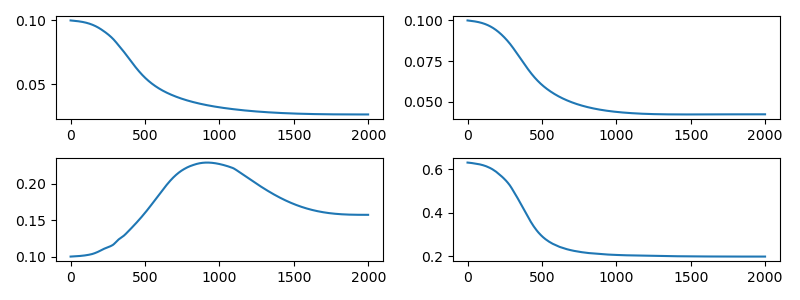

In [12]:
%matplotlib widget
fig, ax = plt.subplots(2, 2, figsize=(8, 3))
ax[0][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 0]))
ax[0][1].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 1]))
ax[1][0].plot(jax.nn.sigmoid(jnp.stack(decays)[:, 2]))
ax[1][1].plot(criteria)
fig.tight_layout()
plt.show()